# Image generation (plus some gold mining)

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib.pyplot as plt

from units import *
from simulation import SubhaloSimulator

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Prior

In [2]:
mass_base_unit = 1.e7 * M_s

In [3]:
alpha_mean = 1000. # 100  # 100 is just 2e8/M_s * mass_base_unit * (mass_base_unit / M_s)**-1.9
alpha_std = alpha_mean * 0.2

print(alpha_mean, "+/-", alpha_std)

beta_mean = -1.9
beta_std = 0.2

1000.0 +/- 200.0


## Draw parameters to generate

In [4]:
n_sims = 50000
n_theta_samples = 100

In [5]:
alpha = np.random.normal(loc=alpha_mean, scale=alpha_std, size=n_sims)
beta = np.random.normal(loc=beta_mean, scale=beta_std, size=n_sims)
parameters = np.vstack((alpha, beta)).T

assert np.min(alpha) > 0.
assert np.max(beta) < -1.

## Generate data

In [6]:
sim = SubhaloSimulator(
    mass_base_unit=mass_base_unit,
    resolution=64,
    m_sub_min=100.,
)

In [7]:
y0 = np.zeros(n_sims)

x0, t_xz0, log_r_xz0, latents0 = sim.rvs_score_ratio(
    alpha,
    beta,
    alpha_mean,
    beta_mean,
    n_sims
)

../profiles.py:62: RuntimeWarning: divide by zero encountered in arctanh
  return np.arctanh(np.sqrt(1-x**2))/(np.sqrt(1-x**2))
../lensing_sim.py:78: RuntimeWarning: invalid value encountered in add
  xg += _xg
../lensing_sim.py:79: RuntimeWarning: invalid value encountered in add
  yg += _yg
/Users/johannbrehmer/anaconda3/envs/lensing/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in less
  return f_raw(*args, **kwargs)
/Users/johannbrehmer/anaconda3/envs/lensing/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in greater
  return f_raw(*args, **kwargs)
19:06 simulation           INFO    Simulating image 2500 / 50000
19:25 simulation           INFO    Simulating image 5000 / 50000
19:43 simulation           INFO    Simulating image 7500 / 50000
20:02 simulation           INFO    Simulating image 10000 / 50000
20:20 simulation           INFO    Simulating image 12500 / 50000
20:38 simulation      

In [8]:
y1 = np.ones(n_sims)

x1, t_xz1, log_r_xz1, latents1 = sim.rvs_score_ratio(
    alpha_mean,
    beta_mean,
    alpha,
    beta,
    n_sims
)

08:31 simulation           INFO    Simulating image 2500 / 50000
08:39 simulation           INFO    Simulating image 5000 / 50000
09:13 simulation           INFO    Simulating image 7500 / 50000
09:27 simulation           INFO    Simulating image 10000 / 50000
09:42 simulation           INFO    Simulating image 12500 / 50000
09:56 simulation           INFO    Simulating image 15000 / 50000
10:13 simulation           INFO    Simulating image 17500 / 50000
10:24 simulation           INFO    Simulating image 20000 / 50000
10:33 simulation           INFO    Simulating image 22500 / 50000
10:43 simulation           INFO    Simulating image 25000 / 50000
10:53 simulation           INFO    Simulating image 27500 / 50000
11:05 simulation           INFO    Simulating image 30000 / 50000
11:16 simulation           INFO    Simulating image 32500 / 50000
11:28 simulation           INFO    Simulating image 35000 / 50000
11:39 simulation           INFO    Simulating image 37500 / 50000
11:50 simulat

In [9]:
x = np.vstack((x0, x1))
y = np.hstack((y0, y1))
parameters = np.vstack((parameters, parameters))
log_r_xz = np.hstack((log_r_xz0, log_r_xz1))
t_xz = np.vstack((t_xz0, t_xz1))
latents = latents0 + latents1

r_xz = np.exp(log_r_xz, dtype=np.float64)
n_subs = np.array([v[0] for v in latents])
m_subs = [v[1] for v in latents]
pos_subs = [np.vstack((v[2], v[3])).T for v in latents]

In [10]:
if not os.path.exists("../data"):
    os.mkdir("../data")

np.save("../data/theta.npy", parameters)
np.save("../data/x.npy", x)
np.save("../data/y.npy", y)
np.save("../data/t_xz.npy", t_xz)
np.save("../data/r_xz.npy", r_xz)
np.save("../data/log_r_xz.npy", log_r_xz)

## A first look at the data

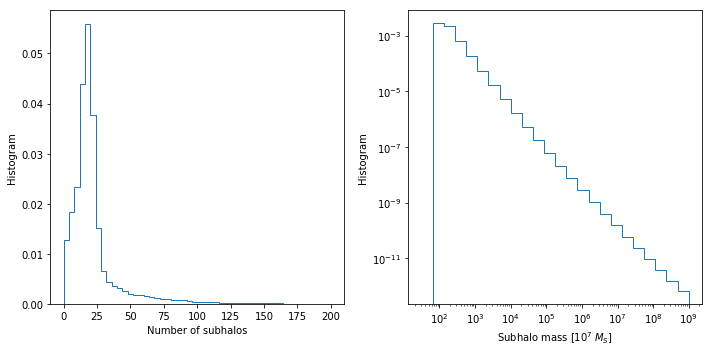

In [21]:
fig = plt.figure(figsize=(10,5))

# Number of subhalos
ax = plt.subplot(1,2,1)
plt.hist(n_subs, bins=50, range=(0,200), histtype='step', density=True)
plt.xlabel(r'Number of subhalos')
plt.ylabel(r'Histogram')

# Masses
ax = plt.subplot(1,2,2)
bins = 10**(np.linspace(1.5, 9, 25))
plt.hist(np.hstack(m_subs), bins=bins, histtype='step', density=True)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
plt.xlabel(r'Subhalo mass [$10^7 \; M_S$]')
plt.ylabel(r'Histogram')

plt.tight_layout()
plt.savefig("subhalo_params.pdf")

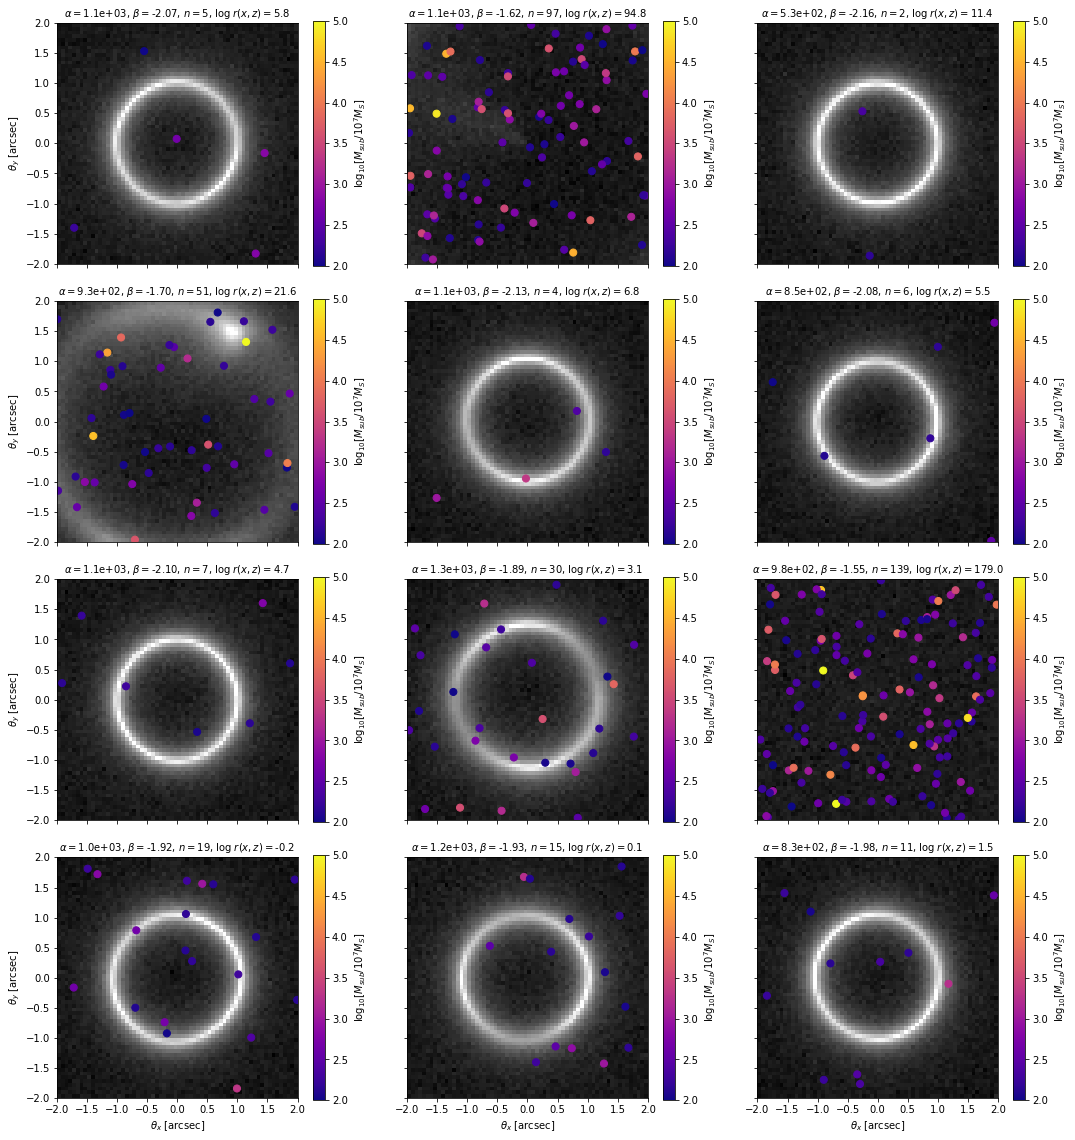

In [22]:
plt.figure(figsize=(15,16))

for i in [9,10,11,0,3,6,1,2,4,5,7,8]:
    if i == 9:
        ax_y = plt.subplot(4,3,i+1)
        ax_x = ax_y
    elif i in [10,11]:
        ax_x = plt.subplot(4,3,i+1, sharey=ax_y)
    elif i in [0,3,6]:
        ax_y = plt.subplot(4,3,i+1, sharex=ax_x)
    else:
        ax = plt.subplot(4,3,i+1, sharey=ax_y, sharex=ax_x)
        
    plt.imshow(
        np.log10(x[i]),
        vmax=3.5,
        cmap='gist_gray',
        extent=(-2.,2.,-2.,2.),
        origin="lower"
    )
    sc = plt.scatter(
        pos_subs[i][:,0],
        pos_subs[i][:,1],
        s=50.,
        c=np.log10(m_subs[i][:]),
        cmap="plasma",
        vmin=2.,
        vmax=5.,
    )
    cbar = plt.colorbar(sc)
    
    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)
    
    description = r"$\alpha = ${:.1e}, $\beta = ${:.2f}, $n = {}$, $\log \; r(x,z) = ${:.1f}".format(
            alpha[i],
            beta[i],
            n_subs[i],
            log_r_xz[i]
        )
    plt.title(
        description,
        fontsize=10
    )
    if i in [9,10,11]:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    if i in [0,3,6,9]:
        plt.ylabel(r"$\theta_y$ [arcsec]")
    else:
        plt.setp(plt.gca().get_yticklabels(), visible=False)
    cbar.set_label(r'$\log_{10} [M_{sub} / 10^7 M_S]$')
    
    
plt.tight_layout()
plt.savefig("subhalos.pdf")